In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint, checkpoint_sequential
from torch.cuda.amp import autocast
from torch.amp.grad_scaler import GradScaler
import matplotlib.pyplot as plt
import time
import gc

In [18]:
def create_text_dataset():
    """Create a simple tokenized text dataset"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25
    }

    sentences = [
        "the cat sat on the mat",
        "the dog ran fast over the lazy cat",
        "the bird flew high over the big tree",
        "the quick brown fox jumps over the lazy dog",
        "the small cat sat on the big mat",
        "the fast dog ran over the small house"
    ]

    # Tokenize and pad
    tokenized = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized.append(tokens)

    # Pad to same length
    max_len = max(len(seq) for seq in tokenized)
    padded = []
    for seq in tokenized:
        padded.append(seq + [0] * (max_len - len(seq)))

    return torch.tensor(padded), vocab

## 💾 Memory Optimization

### Gradient Checkpointing

In [19]:
# Gradient Checkpointing
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# Method 1: Function-based checkpointing
def checkpoint_wrapper(func):
    def wrapper(*args, **kwargs):
        return checkpoint(func, *args, **kwargs)
    return wrapper

# Method 2: Module-based checkpointing
class CheckpointedTransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Use checkpointing to save memory
        x = x + checkpoint(self._attention_block, self.ln1(x), mask)
        x = x + checkpoint(self.ff, self.ln2(x))
        return x

    def _attention_block(self, x, mask):
        return self.attn(x, x, x, attn_mask=mask)[0]

# Method 3: Sequential checkpointing for transformer stack
class CheckpointedTransformerStack(nn.Module):
    def __init__(self, layers, segments=4):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.segments = segments

    def forward(self, x, mask=None):
        # Divide layers into segments for checkpointing
        return checkpoint_sequential(
            self.layers, self.segments, x, mask, preserve_rng_state=True
        )

# Advanced: Selective activation checkpointing
def selective_checkpoint(module, inputs, condition_fn):
    """Only checkpoint if condition is met (e.g., layer depth, memory usage)"""
    if condition_fn(module):
        return checkpoint(module, *inputs)
    else:
        return module(*inputs)


### Gradient Accumulation and Scaling

In [20]:
# Gradient Accumulation and Scaling
class GradientAccumulator:
    def __init__(self, model, accumulation_steps, max_grad_norm=1.0):
        self.model = model
        self.accumulation_steps = accumulation_steps
        self.max_grad_norm = max_grad_norm
        self.current_step = 0

    def backward_and_step(self, loss, optimizer, scheduler=None):
        # Scale loss by accumulation steps
        scaled_loss = loss / self.accumulation_steps
        scaled_loss.backward()

        self.current_step += 1

        # Only step optimizer every accumulation_steps
        if self.current_step % self.accumulation_steps == 0:
            if self.max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            optimizer.step()
            if scheduler:
                scheduler.step()
            optimizer.zero_grad()

    def finalize_step(self, optimizer, scheduler=None):
        """Handle partial accumulation at end of epoch"""
        if self.current_step % self.accumulation_steps != 0:
            if self.max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            optimizer.step()
            if scheduler:
                scheduler.step()
            optimizer.zero_grad()

# Mixed precision training with automatic scaling
from torch.cuda.amp import GradScaler, autocast

class MixedPrecisionTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        # Fix the deprecated GradScaler warning
        try:
            from torch.amp import GradScaler
            self.scaler = GradScaler('cuda')
        except ImportError:
            # Fallback for older PyTorch versions
            from torch.cuda.amp import GradScaler
            self.scaler = GradScaler()

    def training_step(self, inputs, targets):
        with autocast():
            outputs = self.model(inputs)
            loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), targets.view(-1), ignore_index=0)

        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.optimizer.zero_grad()

        return loss.item()



### Memory Optimization Techniques Overview

**1. Gradient Checkpointing**
-----------------------------------
 - Recomputes activations during backward pass
 - Reduces memory usage at cost of computation
  - Essential for training large models

**2. Gradient Accumulation**
----------------------------------------
  - Simulates larger batch sizes
  - Accumulates gradients over multiple mini-batches
  - Helps with memory-limited training

**3. Mixed Precision Training**
-------------------------------------------
  - Uses FP16 for forward pass, FP32 for gradients
  - Automatic loss scaling prevents underflow
  - 2x memory reduction + speed improvement

**4. Selective Checkpointing**
-----------------------------------------------
  - Conditionally applies checkpointing
  - Based on layer depth or memory pressure
  - Fine-tuned memory-compute tradeoffs

Key Benefits:
--------------------------------------------------
    ✓ Gradient Checkpointing: Trades computation for memory
    ✓ Gradient Accumulation: Enables large effective batch sizes
    ✓ Mixed Precision: Reduces memory and increases speed on modern GPUs
    ✓ Selective Checkpointing: Fine-grained memory-compute tradeoffs
    
Usage Instructions:
-----------------------------------------------
1. Use gradient checkpointing for memory-constrained training
2. Apply gradient accumulation when batch size is limited
3. Enable mixed precision on CUDA devices for efficiency
4. Combine techniques for maximum memory savings


In [21]:
# Simple Transformer for testing
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=512, use_checkpointing=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        if use_checkpointing:
            layers = [CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
            self.transformer = CheckpointedTransformerStack(layers, segments=2)
        else:
            self.transformer = nn.ModuleList([
                CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
            ])

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.use_checkpointing = use_checkpointing

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]

        if self.use_checkpointing:
            x = self.transformer(x)
        else:
            for layer in self.transformer:
                x = layer(x)

        x = self.ln_f(x)
        return self.lm_head(x)

In [25]:
def test_memory_optimization():
    """Test gradient checkpointing, accumulation, and mixed precision"""
    print("Testing Memory Optimization Techniques")
    print("=" * 60)

    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create dataset
    data, vocab = create_text_dataset()
    vocab_size = len(vocab)
    seq_len = data.shape[1]

    print(f"Dataset: {data.shape}")
    print(f"Vocabulary size: {vocab_size}")
    print(f"Sequence length: {seq_len}")

    # Model configurations
    d_model = 128
    num_heads = 4
    d_ff = 256
    num_layers = 4

    print(f"\nModel config: d_model={d_model}, heads={num_heads}, layers={num_layers}")

    # Test 1: Compare memory usage with/without checkpointing
    print("\n" + "-" * 50)
    print("Test 1: Gradient Checkpointing")
    print("-" * 50)

    results = {}

    for use_cp in [False, True]:
        gc.collect()
        if device.type == 'cuda':
            torch.cuda.empty_cache()

        model = SimpleTransformer(
            vocab_size, d_model, num_heads, d_ff, num_layers,
            max_seq_len=seq_len, use_checkpointing=use_cp
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
        data_device = data.to(device)

        # Measure memory before training
        if device.type == 'cuda':
            torch.cuda.reset_peak_memory_stats()

        # Forward + backward pass
        model.train()
        outputs = model(data_device)
        targets = data_device  # Simple language modeling target
        loss = F.cross_entropy(outputs.view(-1, vocab_size), targets.view(-1), ignore_index=0)
        loss.backward()

        peak_memory = 0
        if device.type == 'cuda':
            peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB

        results[f"Checkpointing: {use_cp}"] = {
            'loss': loss.item(),
            'peak_memory_mb': peak_memory,
            'num_params': sum(p.numel() for p in model.parameters())
        }

        print(f"Checkpointing: {use_cp}")
        print(f"  Loss: {loss.item():.4f}")
        print(f"  Peak memory: {peak_memory:.1f} MB")
        print(f"  Parameters: {results[f'Checkpointing: {use_cp}']['num_params']:,}")

        del model, optimizer, outputs, loss

    # Test 2: Gradient Accumulation
    print("\n" + "-" * 50)
    print("Test 2: Gradient Accumulation")
    print("-" * 50)

    model = SimpleTransformer(
        vocab_size, d_model, num_heads, d_ff, num_layers,
        max_seq_len=seq_len, use_checkpointing=True
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    accumulator = GradientAccumulator(model, accumulation_steps=4, max_grad_norm=1.0)

    model.train()
    losses = []

    for step in range(8):  # Simulate 8 mini-batches
        outputs = model(data.to(device))
        targets = data.to(device)
        loss = F.cross_entropy(outputs.view(-1, vocab_size), targets.view(-1), ignore_index=0)

        accumulator.backward_and_step(loss, optimizer)
        losses.append(loss.item())

        if (step + 1) % 4 == 0:
            print(f"  Step {step+1}: Avg loss over 4 batches = {sum(losses[-4:]) / 4:.4f}")

    accumulator.finalize_step(optimizer)

    # Test 3: Mixed Precision Training
    print("\n" + "-" * 50)
    print("Test 3: Mixed Precision Training")
    print("-" * 50)

    if device.type == 'cuda':
        model = SimpleTransformer(
            vocab_size, d_model, num_heads, d_ff, num_layers,
            max_seq_len=seq_len, use_checkpointing=True
        ).to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
        trainer = MixedPrecisionTrainer(model, optimizer)

        model.train()
        mp_losses = []

        for step in range(5):
            # Pass inputs and targets correctly
            inputs = data.to(device)
            targets = data.to(device)
            loss = trainer.training_step(inputs, targets)
            mp_losses.append(loss)
            print(f"  Step {step+1}: Mixed precision loss = {loss:.4f}")
    else:
        print("  Mixed precision requires CUDA - skipping on CPU")

    # Visualization
    print("\n" + "-" * 50)
    print("Visualization: Training Loss")
    print("-" * 50)

    plt.figure(figsize=(12, 4))

    # Plot gradient accumulation losses
    plt.subplot(1, 2, 1)
    plt.plot(losses, 'b-o', markersize=4)
    plt.title('Gradient Accumulation Training')
    plt.xlabel('Mini-batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

    # Plot memory comparison if CUDA available
    plt.subplot(1, 2, 2)
    if device.type == 'cuda':
        methods = ['Without Checkpointing', 'With Checkpointing']
        memory_usage = [results['Checkpointing: False']['peak_memory_mb'],
                       results['Checkpointing: True']['peak_memory_mb']]
        colors = ['red', 'green']

        bars = plt.bar(methods, memory_usage, color=colors, alpha=0.7)
        plt.title('Peak Memory Usage Comparison')
        plt.ylabel('Memory (MB)')

        # Add value labels on bars
        for bar, value in zip(bars, memory_usage):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f} MB', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'CUDA required for\nmemory measurements',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Memory Usage (CUDA Required)')

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("Memory Optimization Tests Completed!")
    print("=" * 60)


    return results


Testing Memory Optimization Techniques
Using device: cuda
Dataset: torch.Size([6, 11])
Vocabulary size: 26
Sequence length: 11

Model config: d_model=128, heads=4, layers=4

--------------------------------------------------
Test 1: Gradient Checkpointing
--------------------------------------------------
Checkpointing: False
  Loss: 3.3225
  Peak memory: 25.9 MB
  Parameters: 538,266
Checkpointing: True
  Loss: 3.7527
  Peak memory: 26.0 MB
  Parameters: 538,266

--------------------------------------------------
Test 2: Gradient Accumulation
--------------------------------------------------
  Step 4: Avg loss over 4 batches = 3.4042
  Step 8: Avg loss over 4 batches = 3.2798

--------------------------------------------------
Test 3: Mixed Precision Training
--------------------------------------------------


/tmp/ipython-input-3405881326.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Step 1: Mixed precision loss = 3.4240
  Step 2: Mixed precision loss = 3.3088
  Step 3: Mixed precision loss = 3.1948
  Step 4: Mixed precision loss = 3.0822
  Step 5: Mixed precision loss = 2.9722

--------------------------------------------------
Visualization: Training Loss
--------------------------------------------------


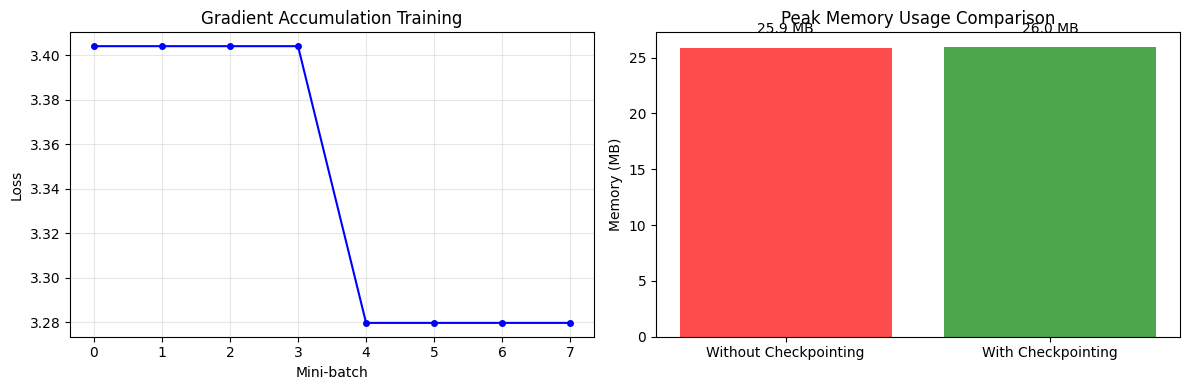


Memory Optimization Tests Completed!


In [26]:
# Run comprehensive test
test_results = test_memory_optimization()